# Fatir

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
# Assume that a and b are the parameters of Gaussian output by the encoder
a = torch.rand([1]) + 0.5
b = torch.rand([1]) + 1
a.requires_grad_()
b.requires_grad_()

tensor([1.9150], requires_grad=True)

In [4]:
# Assume that this class is an Invertible Neural Network
# It's just an exp <--> log pair essentially
class ExpNF:
    def __init__(self, base):
        self.base = base
        self.mean = nn.Parameter(torch.zeros([1]))
    def forward(self, x):
        return torch.exp(x + self.mean)
    def inverse(self, y):
        return torch.log(y) - self.mean
    def LDT(self, x):
        return -torch.abs(x + self.mean)
    def iLDT(self, y):
        return torch.log(1/(y))
    def log_prob(self, y):
        # Log-prob of a point under the NF. Uses the inverse formula.
        return base.log_prob(self.inverse(y)) + self.iLDT(y)

In [5]:
base = torch.distributions.normal.Normal(a, b) # The base distribution: Gaussian
exp_nf = ExpNF(base) # The Normalizing Flow: Base + Exp. Essentially becomes a log-normal

In [6]:
z = torch.rand([10, 1]) # Start from a random point
z.requires_grad_()
noise = torch.randn([10, 1]) # Brownian noise
eta = 0.01 # Step size
lp = exp_nf.log_prob(z) # Target log density

In [7]:
lp = lp.sum()

In [7]:
grad = torch.autograd.grad(
    lp, 
    z, 
    grad_outputs=torch.ones_like(z), 
    create_graph=True, 
    retain_graph=True)[0]


In [8]:
z_t = z + eta*grad + np.sqrt(2 * eta) * noise # Langevin update

In [10]:
z_t.backward(gradient=torch.ones_like(z_t)) # Checking if the backward pass works

In [11]:
a.grad, b.grad, exp_nf.mean.grad # It does!

(tensor([0.0664]), tensor([-0.1744]), tensor([0.0664]))

In [11]:
a.grad, b.grad, exp_nf.mean.grad # It does!

(tensor([0.0664]), tensor([-0.1744]), tensor([0.0664]))

# VI Test

In [1]:
import torch.nn as nn

In [3]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def reparameterize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)

        return self.reparameterize(mu, log_var), mu, log_var

In [12]:
def ll_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

In [14]:
def elbo(y_pred, y, mu, log_var):
    likelihood = ll_gaussian(y, mu, log_var)

    log_prior = ll_gaussian(y_pred, 0, torch.log(torch.tensor(1.)))

    log_p_q = ll_gaussian(y_pred, mu, log_var)

    return (likelihood + log_prior - log_p_q).mean()

def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var)

def det_loss(y, y_pred, mu, log_var):
    reconstruction_error = (0.5 * (y - y_pred)**2).sum()
    kl_divergence = (-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp()))

    return (reconstruction_error + kl_divergence).sum()

# Toy Example Test

In [82]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence
import torch.optim as optim
import matplotlib.pyplot as plt

In [92]:
class NormalDist(nn.Module):
    def __init__(self, n_dim):
        super().__init__()
        
        self.loc = nn.Parameter(torch.randn(n_dim), requires_grad=True)
        self.log_scale = nn.Parameter(torch.zeros(n_dim), requires_grad=True)
        # How to initialize point?
        self.prev_sample = torch.randn(n_dim)

    def get_dist(self):
        return Normal(self.loc, self.log_scale.exp())


In [87]:
def f_theta(z, q_dist, p_dist):
    return q_dist.log_prob(z).sum() - \
        p_dist.log_prob(z).sum()

def langevin_step(z, q_dist, eta=0.01):
    noise = torch.randn_like(z)
    log_q = q_dist.log_prob(z).sum()
    grad = torch.autograd.grad(log_q, z, create_graph=True)[0]

    return z + eta*grad + torch.sqrt(2*eta)*noise

def reparam_kl(q_dist, p_dist):
    q_sample = q_dist.rsample()

    f = f_theta(q_sample, q_dist, p_dist)

    return f

def reinforce_kl(q_dist, p_dist):
    # Don't reparameterize
    q_sample = q_dist.sample()

    f = f_theta(q_sample, q_dist, p_dist)

    return q_dist.log_prob(q_sample).sum() * f.detach() + f

def langevin_kl(q_model, p_dist, s, t):
    q_dist = q_model.get_dist()
    z = q_model.prev_sample

    # Run chain w/o reparameterization
    with torch.no_grad():
        for _ in range(s):
            z = langevin_step(z, q_dist)

    # Run chain w reparameterization
    for _ in range(t):
        z = langevin_step(z, q_dist)
    
    f = f_theta(z, q_dist, p_dist)

    return f

In [88]:
n_iter = 4000

loc = torch.tensor([1., 2.])
scale = torch.tensor([1., 5.])
p_dist = Normal(loc, scale)

q_model = NormalDist(n_dim=2)

optimizer = optim.SGD(q_model.parameters(), lr=1e-3)
# optimizer = optim.Adam(q_model.parameters(), lr=1e-3)

In [89]:
kls = []

for i in range(n_iter):
    optimizer.zero_grad()

    q_dist = q_model.get_dist()

    loss = reinforce_kl(q_dist, p_dist)

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        kl = kl_divergence(q_model.get_dist(), p_dist).mean().item()
        kls.append(kl)

In [90]:
list(q_model.parameters())[1].exp()

tensor([0.9708, 4.7722], grad_fn=<ExpBackward>)

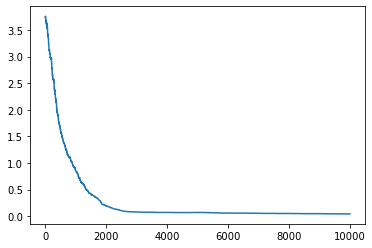

In [91]:
plt.plot(kls)

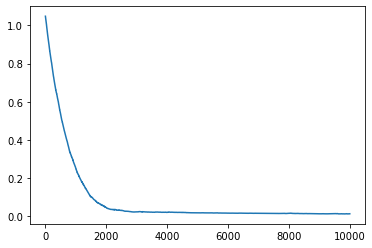

In [81]:
plt.plot(kls)